### **1. Importando bibliotecas**

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score

### **2. Carregando o dataset**

In [14]:
bankchurners = pd.read_csv('BankChurners.csv') 
bankchurners.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


### **3.Limpeza dos dados**

In [15]:
# removendo colunas desnecessárias
if 'CLIENTNUM' in bankchurners.columns:
    bankchurners.drop(['CLIENTNUM'], axis=1, inplace=True)
bankchurners.drop(columns=[col for col in bankchurners.columns if "Unnamed" in col], inplace=True)

# removendo colunas especificas do Naive Bayes 
bankchurners.drop([
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
], axis=1, inplace=True)

In [16]:
# verificando valores nulos
bankchurners.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [17]:
bankchurners['Gender'] = bankchurners['Gender'].map({'M':1,"F":0})
bankchurners['Attrition_Flag'] = bankchurners['Attrition_Flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

In [18]:
bankchurners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  int64  
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

## **V. Feature Engineering and Selection**

In [19]:
bankchurners.drop(['Marital_Status', 'Card_Category'], axis=1, inplace=True)

In [20]:
# One-hot encoding para colunas multicategóricas
## Converter variáveis categóricas (características com categorias discretas) em um formato binário que os modelos de aprendizado de máquina possam usar de forma mais eficaz, especialmente quando não há uma ordem inerente entre as categorias.  
bankchurners = pd.get_dummies(bankchurners, columns=['Education_Level', 'Income_Category'], drop_first=True)


In [21]:
scaler = StandardScaler()
numerical_features = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct']
bankchurners[numerical_features] = scaler.fit_transform(bankchurners[numerical_features])


In [22]:
from sklearn.decomposition import PCA
scaled_data = bankchurners[['Total_Trans_Amt', 'Total_Trans_Ct']]
pca = PCA(n_components=1)  # Giảm về 1 chiều
bankchurners['Total_Trans_PCA'] = pca.fit_transform(scaled_data)

/home/wellison/.local/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0.02868127 0.01593248 0.02268338 0.02564022 0.07324702 0.03641038
 0.04195403 0.03051753 0.10550894 0.02894706 0.04359102 0.11828071
 0.1330072  0.06289734 0.04486405 0.00502965 0.0113474  0.0089
 0.00580847 0.00852041 0.00919036 0.00775355 0.00612701 0.00687452
 0.00858961 0.0059898  0.10370661]


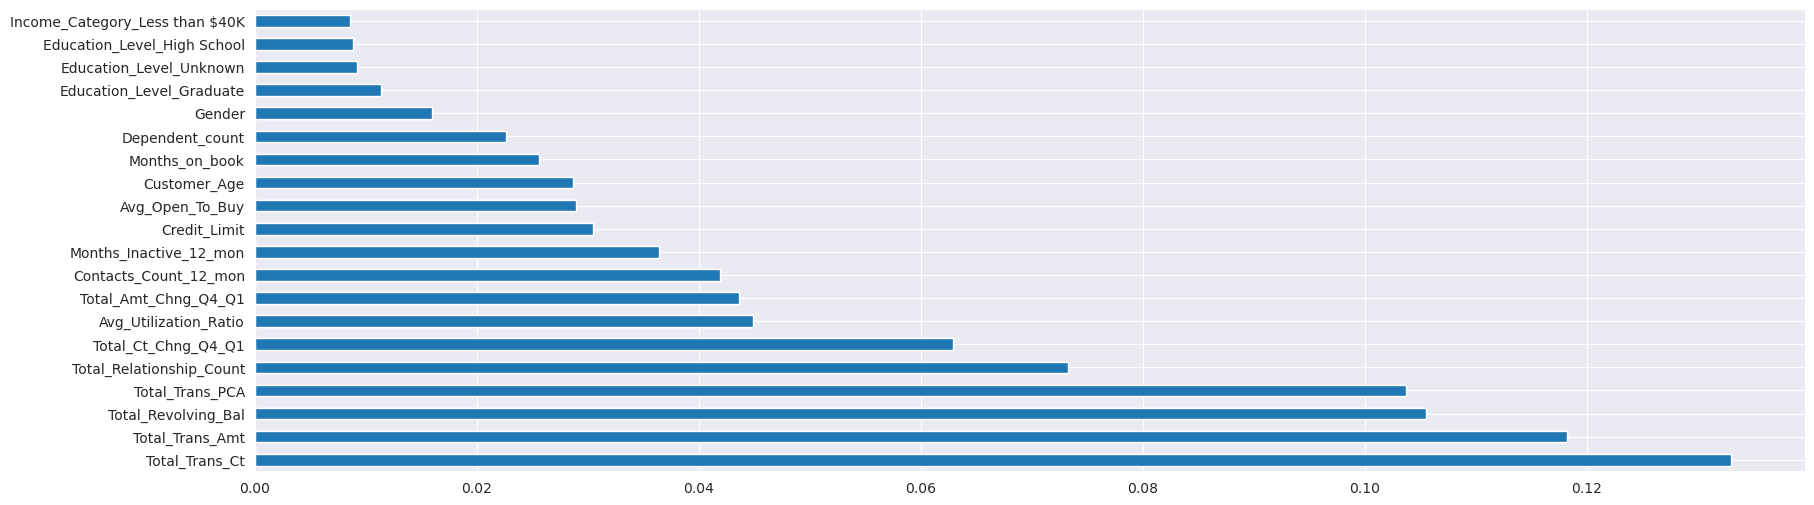

In [23]:
plt.figure(figsize = (20,6))
sns.set_style('darkgrid')

x = bankchurners.loc[:, bankchurners.columns !='Attrition_Flag']
y = bankchurners.loc[:, bankchurners.columns == 'Attrition_Flag']

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index = x.columns)
img = feat_importances.nlargest(20).plot(kind = 'barh')
labels1 = feat_importances.nlargest(20).plot(kind = 'barh').get_yticklabels()
plt.show()

In [24]:
required_labels = list()
for i in labels1:
    j = str(i)
    required_labels.append(j[12:len(j)-2])

## **V. Model Implementation**
### **1. Data Splitting**

In [25]:

X = bankchurners.drop('Attrition_Flag', axis=1)  
y = bankchurners['Attrition_Flag']  

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

***Razões para escolher Random Forest***  
- ***Lida com Relações Não Lineares:*** Como o conjunto de dados contém variáveis numéricas e categóricas, o Random Forest pode capturar relações complexas e não lineares entre as features e a variável alvo (evasão).  

- ***Manejo de Dados Desbalanceados:*** A capacidade do Random Forest de utilizar bootstrap e agregar resultados de múltiplas árvores pode ajudar a equilibrar a influência de classes minoritárias, como clientes que cancelaram (16,07%) neste caso.  

- ***Redução do impacto de outliers:*** O Random Forest é menos sensível a outliers, tornando-se ideal para features como **Total_Revolving_Bal, Avg_Open_To_Buy e Total_Trans_Amt**, que possuem valores extremos. As divisões baseadas em árvores ajudam a reduzir o impacto desses valores extremos, capturando padrões de forma mais eficaz.  

***A principal intuição por trás do algoritmo:***  
- **Amostragem Bootstrap:** Cada árvore é treinada em um subconjunto aleatório dos dados (com reposição), introduzindo variedade e reduzindo a variância.  

- **Seleção Aleatória de Features:** A cada divisão, apenas um subconjunto aleatório de features é considerado, evitando que uma única feature domine e garantindo árvores mais diversas.  

- **Votação em Conjunto (Ensemble Voting):** Para classificação, cada árvore "vota" na classe e a maioria dos votos define a previsão final. Essa abordagem de conjunto ajuda a suavizar erros e melhora a precisão.  

***Ajuste de Hiperparâmetros para Random Forest:***  
- Número de Árvores (**n_estimators**): define a quantidade de árvores na floresta  
  - **n_estimators = 100**  
- Profundidade Máxima (**max_depth**): profundidade máxima de cada árvore  
  - **max_depth = 50**  
- Mínimo de Amostras por Folha (**min_samples_leaf**): número mínimo de amostras necessárias para formar uma folha  
  - **min_samples_leaf = 5**  
- Mínimo de Amostras para Divisão (**min_samples_split**): número mínimo de amostras necessárias para dividir um nó interno em uma árvore de decisão  
  - **min_samples_split = 20**  
- Peso das Classes (**class_weight**): atribui pesos diferentes às classes, ajudando a lidar com conjuntos de dados desbalanceados  
  - **class_weight = 'balanced'**  


In [27]:
rfcl = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=20, min_samples_leaf=5, class_weight='balanced',random_state=42)
rfcl = rfcl.fit(X_train, y_train)

In [28]:
y_train_rf = rfcl.predict(X_train)

In [29]:
y_test_rf = rfcl.predict(X_test)

## **VI. Avaliação do modelo**

In [30]:
print("Model Accuracy:", rfcl.score(X_train, y_train))

Model Accuracy: 0.9738995485327314


In [31]:
print("Model Accuracy:", rfcl.score(X_test, y_test))

Model Accuracy: 0.9526159921026653


In [32]:
cm_rf = confusion_matrix(y_test, y_test_rf, labels=[0, 1])  # 1 = Churn, 0 = No Churn

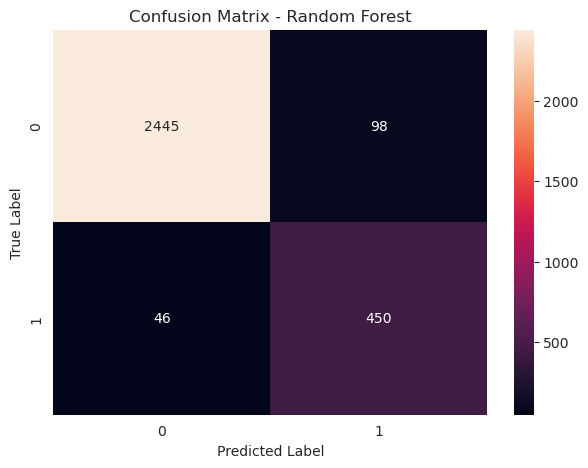

In [33]:
df_cm_rf = pd.DataFrame(cm_rf)

plt.figure(figsize=(7, 5))
sns.heatmap(df_cm_rf, annot=True, fmt='g')
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [34]:
print(classification_report(y_test, y_test_rf))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2543
           1       0.82      0.91      0.86       496

    accuracy                           0.95      3039
   macro avg       0.90      0.93      0.92      3039
weighted avg       0.96      0.95      0.95      3039



In [35]:
from sklearn.model_selection import StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


cv_scores = cross_val_score(rfcl, X, y, cv=stratified_kfold)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")


y_pred = cross_val_predict(rfcl, X, y, cv=stratified_kfold)


print(classification_report(y, y_pred))

Cross-validation scores: [0.94669299 0.94866732 0.96051333 0.95459033 0.94076999 0.96248766
 0.94570582 0.95849802 0.96936759 0.96146245]
Mean cross-validation score: 0.9548755506479013
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8500
           1       0.83      0.91      0.87      1627

    accuracy                           0.95     10127
   macro avg       0.90      0.94      0.92     10127
weighted avg       0.96      0.95      0.96     10127



In [36]:
print("ROC AUC Score:", roc_auc_score(y_test, rfcl.predict_proba(X_test)[:, 1]))

ROC AUC Score: 0.9867322377684473


In [37]:
cv_scores = cross_val_score(rfcl, X, y, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean()}")

Cross-Validation ROC AUC Scores: [0.89731685 0.98404908 0.99460452 0.99761086 0.67412579]
Mean ROC AUC Score: 0.9095414218693613


**Discussão sobre os Pontos Fortes e Fracos do Modelo Random Forest**

***1. Pontos Fortes***  
- **Manejo de Desequilíbrio de Classes**: O parâmetro ***class_weight='balanced'*** ajusta a função de perda do modelo para dar mais importância à classe minoritária, permitindo que o Random Forest foque mais na previsão de clientes que irão cancelar (classe 1). Isso resulta em:  
  - **Maior recall** para cancelamento (classe 1), o que é crucial para prever quem provavelmente irá sair. O recall é particularmente importante na previsão de cancelamento, pois garante que a maioria dos clientes que sairão sejam identificados.  

  - **F1-score para cancelamento:** O F1-score para clientes cancelados no conjunto de treino é 0,93, indicando um bom equilíbrio entre precisão e recall. No conjunto de teste, é 0,87, mostrando que, embora possa haver espaço para melhorias, o modelo ainda identifica eficazmente os clientes em risco.  

- **Desempenho no Conjunto de Teste**  
  - **Acurácia**: O modelo alcança uma acurácia de 94,80% no conjunto de teste, refletindo um bom desempenho geral.  

  - **Precisão e Recall para Cancelamento:** A precisão para cancelamento é 0,82 e o recall é 0,88 no conjunto de teste. Isso mostra que o modelo é bastante eficaz em identificar clientes que irão cancelar (alto recall), com alguns falsos positivos (precisão moderada).  

- **Desempenho na Validação Cruzada**  
  - Ao usar Validação Cruzada Estratificada (5-fold), a acurácia média da validação cruzada é 95,17%, com desempenho consistente e estável em todas as dobras. Isso é um indicativo importante de como o modelo se generaliza para dados não vistos.  
  - O score ROC AUC para o processo de validação cruzada é 0,98, sugerindo que o modelo é muito eficaz em distinguir entre clientes que cancelam e os que não cancelam.  

  > A validação cruzada estratificada garante uma distribuição equilibrada de instâncias de cancelamento e não cancelamento em cada dobra, resultando em uma avaliação mais confiável do desempenho do modelo em conjuntos de dados desbalanceados.  

***2. Pontos Fracos***  
- **Interpretabilidade**  
  - Embora a importância das features possa ajudar a entender quais variáveis influenciam as previsões, o Random Forest continua sendo um ***modelo de caixa-preta*** quando se trata de explicar previsões individuais. Isso pode ser um ***desafio para stakeholders que precisam entender por que um determinado cliente foi previsto como provável de cancelar ou não.***  

  - Para empresas que dependem de processos de decisão transparentes, a falta de clareza sobre como o Random Forest chega às previsões pode dificultar sua adoção.  

- **Dificuldade com Desequilíbrios Extremos de Classe:** Apesar do uso de pesos de classe e da obtenção de um alto recall, o modelo ainda pode enfrentar desafios para prever com precisão os clientes que irão cancelar quando o desbalanceamento de classes for particularmente severo.  
  ***Em aplicações práticas, onde a taxa de desbalanceamento pode variar, há um risco significativo de que o modelo não consiga identificar de forma confiável os clientes que irão cancelar, levando a previsões menos eficazes.***  


In [38]:
y_predict = rfcl.predict(X_test)
churned_customers = X_test[y_predict == 0]

In [39]:
print("Churned Customers:")
print(churned_customers)

Churned Customers:
      Customer_Age  Gender  Dependent_count  Months_on_book  \
3781      0.208826       0         0.503368        0.384621   
2922      1.581010       1        -1.036462        2.137684   
5070     -1.163358       0        -0.266547        0.008965   
7246      0.084082       1         0.503368        0.008965   
623      -0.539638       1         0.503368       -0.366692   
...            ...     ...              ...             ...   
6621      0.333570       1         1.273283       -0.742348   
9535     -0.913870       1        -1.036462        0.008965   
4638      1.206778       1        -0.266547        1.511590   
1166     -1.038614       0        -0.266547        0.008965   
254       2.953194       1        -1.806378        2.513340   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
3781                  0.120579                0.651940               1.396424   
2922                  0.763943                2.631016        